In [1]:
import xarray as xr
import xroms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy

# How to select data

The [load_data](load_data.ipynb) notebook demonstrates how to load in data, but now how to select out parts of it?

With the `xroms` accessor, you can use xarray `sel` and `isel` commands for a DataArray without needing to input the exact grid, and `xroms` will just use the relevant grid.

Instead of

    ds.salt.xroms.isel(xi_rho=20, eta_rho=10, s_rho=20, ocean_time=10)

can use:

    ds.salt.xroms.isel(xi=20, eta=10, s=20, t=10)
    
and get the same thing back. Same for `sel`.

### Load in data

More information at in [load_data notebook](load_data.ipynb)

In [2]:
loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/forecast_latest/txla2_his_f_latest.nc'
chunks = {'ocean_time':1}
ds = xroms.open_netcdf(loc, chunks=chunks)

## Select

### Slices by index or keyword

#### Surface layer slice

The surface in ROMS is given by the last index in the vertical dimension. The easiest way to access this is by indexing into `s_rho`. While normally it is better to access coordinates through keywords to be human-readable, it's not easy to tell what value of `s_rho` gives the surface. In this instance, it's easier to just go by index.

In [8]:
ds.salt.isel(s_rho=-1);

# or with xroms accessor:
ds.salt.xroms.isel(s=-1);

#### x/y index slice

For a curvilinear ROMS grid, selecting by the dimensions `xi_rho` or `eta_rho` (or for whichever is the relevant grid) is not very meaningful because they are given by index. Thus the following is possible to get a slice along the index, but it cannot be used to find a slice based on the lon/lat values.

In [9]:
ds.temp.sel(xi_rho=20);

ds.temp.xroms.sel(xi=20);  # same with xroms accessor

#### Single time

Find the forecast model output available that is closest to now. Note that the `method` keyword argument is not necessary if the desired date/time is exactly a model output time.

In [3]:
now = pd.Timestamp.today()

In [4]:
ds.salt.isel(s_rho=-1).sel(ocean_time=now, method='nearest');

ds.salt.xroms.isel(s=-1).xroms.sel(t=now, method='nearest');  # same with xroms accessor

#### Range of time

In [5]:
ds.salt.sel(ocean_time=slice(now, now+pd.Timedelta('2 days')));

ds.salt.xroms.sel(t=slice(now, now+pd.Timedelta('2 days')));  # same with xroms accessor

### Calculate slice

#### Cross-section along a longitude value

Because the example grid is curvilinear, a slice along a grid dimension is not the same as a slice along a longitude or latitude (or projected $x$/$y$) value. This needs to be calculated and we can use the `xisoslice` function to do this. The calculation is done lazily. We calculate only part of the slice, on the continental shelf. Renaming the subsetted dataset (below, as `dss`) is convenient because this variable can be used in place of `ds` for all related function calls to be consistent and only have to subset one time.

In [14]:
# want salinity along this constant value
lon0 = -91.5

# This is the array we want projected onto the longitude value. 
# Note that we are requesting multiple times at once.
dss = ds.isel(ocean_time=slice(0,10), eta_rho=slice(50,-1))

# Projecting 3rd input onto constant value lon0 in iso_array ds.lon_rho
sl = xroms.xisoslice(dss.lon_rho, lon0, dss.salt, 'xi_rho')

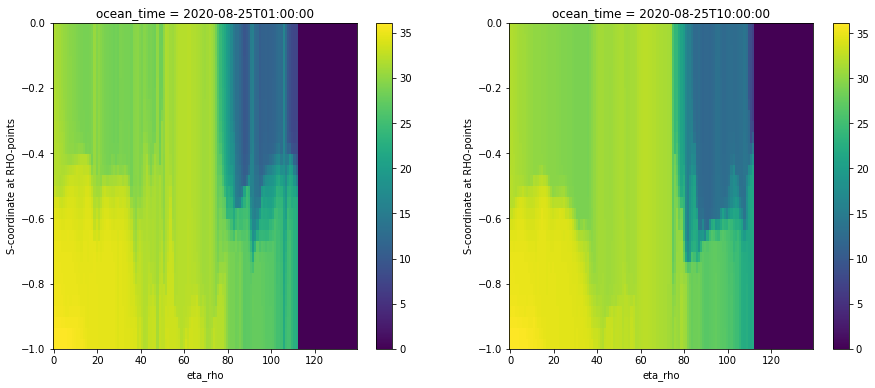

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))

sl.isel(ocean_time=0).plot(ax=axes[0])
sl.isel(ocean_time=-1).plot(ax=axes[1])

Better plot: use coordinates and one colorbar to compare. See more plotting examples in the examples notebook `plotting.ipynb`.

In [16]:
# calculate z values (s_rho)
slz = xroms.xisoslice(dss.lon_rho, lon0, dss.z_rho, 'xi_rho')

# calculate latitude values (eta_rho)
sllat = xroms.xisoslice(dss.lon_rho, lon0, dss.lat_rho, 'xi_rho')

# assign these as coords to be used in plot
sl = sl.assign_coords(z=slz, lat=sllat)

# points that should be masked
slmask = xroms.xisoslice(dss.lon_rho, lon0, dss.mask_rho, 'xi_rho')

# drop masked values
sl = sl.where(slmask==1, drop=True)

# find min and max of the slice itself (without values that should be masked)
vmin = sl.min().values
vmax = sl.max().values


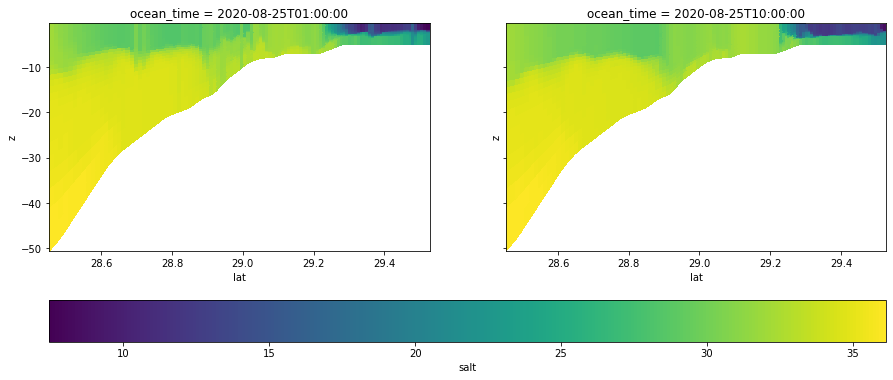

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15,6), sharey=True)

sl.isel(ocean_time=0).plot(x='lat', y='z', ax=axes[0], vmin=vmin, vmax=vmax, add_colorbar=False)
mappable = sl.isel(ocean_time=-1).plot(x='lat', y='z', ax=axes[1], vmin=vmin, vmax=vmax, add_colorbar=False)

fig.colorbar(ax=axes, mappable=mappable, orientation='horizontal').set_label('salt')

Verify performance of isoslice by comparing slice at surface with planview surface plot.

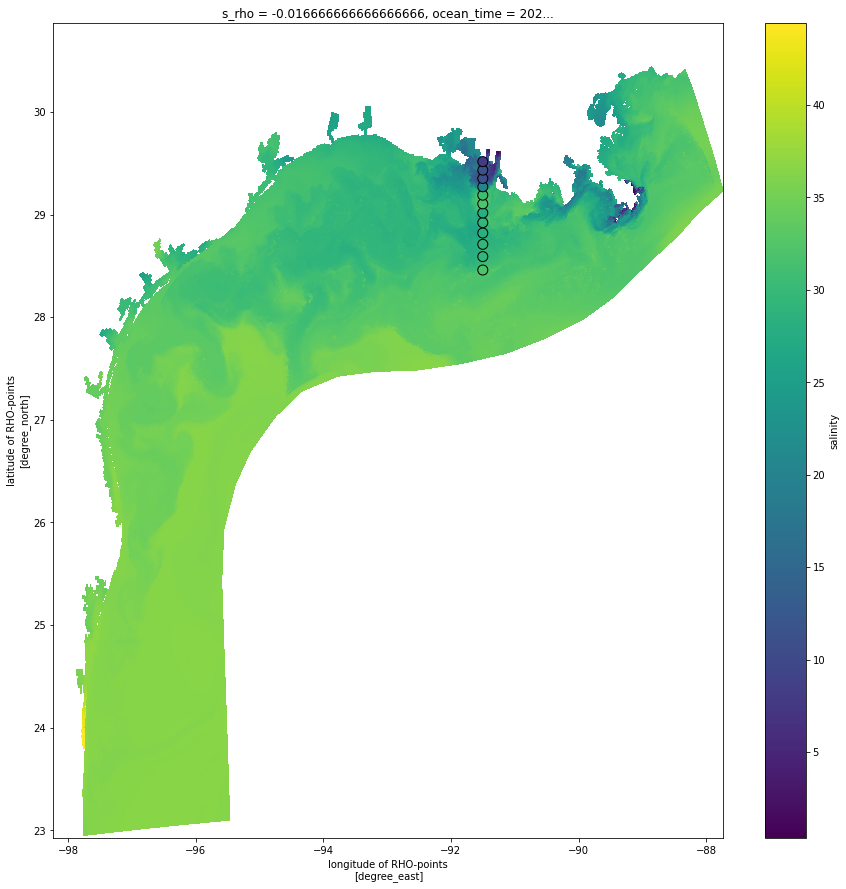

In [18]:
vmin = dss.salt.min().values
vmax = dss.salt.max().values


fig, ax = plt.subplots(1, 1, figsize=(15,13))
ds.salt.isel(ocean_time=0, s_rho=-1).plot(ax=ax, x='lon_rho', y='lat_rho')
ax.scatter(lon0*np.ones_like(sl.lat[::10]), sl.lat[::10], c=sl.isel(ocean_time=0, s_rho=-1)[::10], 
           s=100, vmin=vmin, vmax=vmax, zorder=10, edgecolor='k')

#### Variable at constant z value

In [19]:
# want temperature along this constant depth value
z0 = -10

# This is the array we want projected 
dss = ds.isel(ocean_time=0)

# Projecting 3rd input onto constant value z0 in iso_array (1st input)
sl = xroms.xisoslice(dss.z_rho, z0, dss.temp, 's_rho')

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


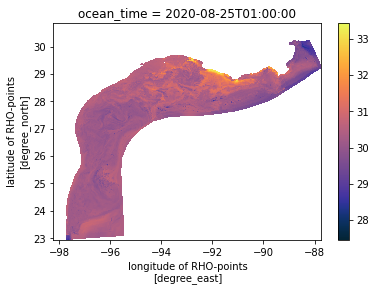

In [20]:
sl.plot(cmap=cmo.thermal, x='lon_rho', y='lat_rho')

#### Variable at constant z depth, in time

In [22]:
# want temperature along this constant depth value
z0 = -10

# Projecting 3rd input onto constant value z0 in iso_array (1st input)
sl = xroms.xisoslice(ds.z_rho, z0, ds.temp, 's_rho')

#### zeta at constant z depth, in time

... to verify that xisoslice does act in time across zeta.

In [23]:
# want temperature along this constant depth value
z0 = -10

# Projecting 3rd input onto constant value z0 in iso_array (1st input)
zeta_s_rho = ds.zeta.expand_dims({'s_rho': ds.s_rho}).transpose('ocean_time','s_rho',...)
sl = xroms.xisoslice(ds.z_rho, z0, zeta_s_rho, 's_rho')

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


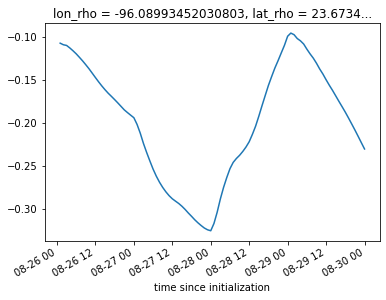

In [25]:
sl.sel(eta_rho=30,xi_rho=20).plot()

#### Depth of isohaline surface

Calculate the depth of a specific isohaline.

Note that in this case there are a few wonky values, so we should filter them out or control the vmin/vmax values on the plot.

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


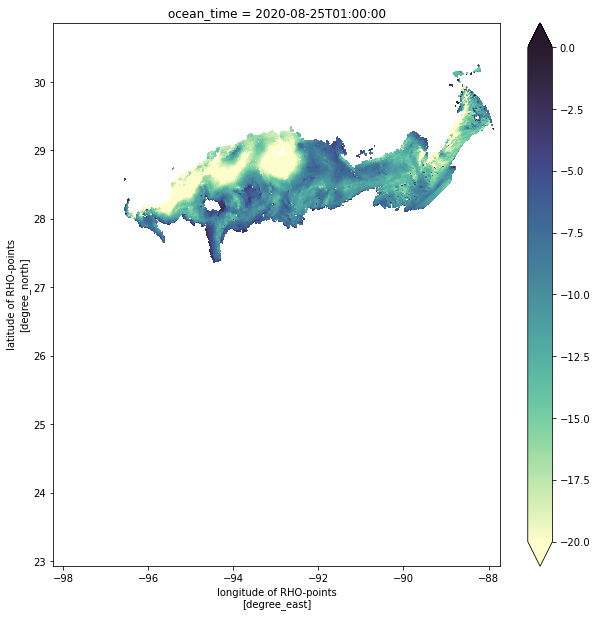

In [26]:
# want the depth of this constant salinity value
S0 = 33

# This is the array we want projected 
dss = ds.isel(ocean_time=0)

# Projecting 3rd input onto constant value z0 in iso_array (1st input)
sl = xroms.xisoslice(dss.salt, S0, dss.z_rho, 's_rho')

sl.plot(cmap=cmo.deep, x='lon_rho', y='lat_rho', vmin=-20, vmax=0, figsize=(10, 10))

#### Variable at distance from seabed

Calculate the salinity at 10 meters above the seabed. Either do this on the vertical rho grid, or first change to the w grid and then use `xisoslice`. You may prefer to do the latter if there is a possibility that the distance above the seabed you are interpolating to (10 m) could be below the deepest rho grid depth.

on rho grid directly:

    sl = xroms.xisoslice(ds.z_rho + ds.h, 10., ds.salt, 's_rho')
    
on w grid:

    var_w = xroms.to_s_w(ds.salt, ds.xroms.grid)
    sl = xroms.xisoslice(ds.z_w + ds.h, 10., var_w, 's_w')


### Select region

Select a boxed region by min/max lon and lat values.

In [27]:
# want model output only within the box defined by these lat/lon values
lon = np.array([-97, -96])
lat = np.array([28, 29])

In [28]:
# this condition defines the region of interest
box = ((lon[0] < ds.lon_rho) & (ds.lon_rho < lon[1]) & (lat[0] < ds.lat_rho) & (ds.lat_rho < lat[1])).compute()

Plot the model output in the box at the surface

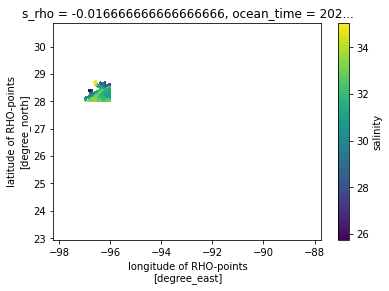

In [29]:
dss = ds.where(box).salt.isel(s_rho=-1, ocean_time=0)
dss.plot(x='lon_rho', y='lat_rho')

Can calculate a metric within the box:

In [30]:
dss.mean().values

array(31.677965, dtype=float32)

### Find nearest model output in two dimensions

This matters for a curvilinear grid.

Can't use `sel` because it will only search in one coordinate for the nearest value and the coordinates are indices which are not necessarily geographic distance. Instead need to use a search for distance and use that for the `where` condition from the previous example.

Find the model output at the grid node nearest the point (lon0, lat0). You can create the projection to use for the distance calculation in `sel2d` and input it into the function, or you can let it choose a default for you.

In [31]:
lon0, lat0 = -96, 27
dl = 0.05
proj = cartopy.crs.LambertConformal(central_longitude=-98, central_latitude=30)

In [32]:
dssub = xroms.sel2d(ds, lon0, lat0, proj, 'rho')

Or, if you instead want the indices of the nearest grid node returned, you can call `argsel2d`:

In [35]:
ix, iy = xroms.argsel2d(ds, lon0, lat0, 'rho', proj)

Check this function, just to be sure:

(26.95, 27.05)

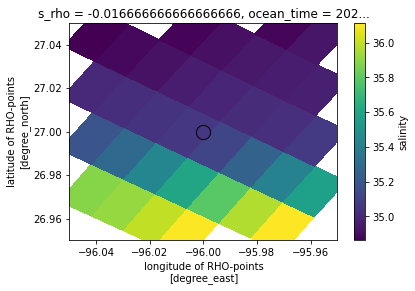

In [36]:
box = (ds.lon_rho>lon0-dl) & (ds.lon_rho<lon0+dl) & (ds.lat_rho>lat0-dl) & (ds.lat_rho<lat0+dl)
dss = ds.where(box).salt.isel(ocean_time=0, s_rho=-1)

vmin = dss.min().values
vmax = dss.max().values

dss.plot(x='lon_rho', y='lat_rho')
plt.scatter(lon0, lat0, c=dssub.salt.isel(s_rho=-1, ocean_time=0), s=200, edgecolor='k', vmin=vmin, vmax=vmax)
plt.xlim(lon0-dl,lon0+dl)
plt.ylim(lat0-dl, lat0+dl)

Note that the `sel2d` function returned a time series since that was input, and it worked fine. Getting the numbers take time.

/Users/kthyng/opt/miniconda3/envs/env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


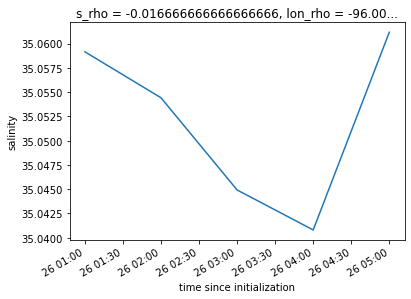

In [37]:
dssub.salt.isel(s_rho=-1, ocean_time=slice(0,5)).plot()